## 뉴욕시의 Taxi 데이터 활용한 예측 모델
---
- 데이터셋 : 케글의 NYC_taxi.csv
- 조건 : 뉴욕시 내
- 거리에 따른 요금 예측 ==> 회귀
- 승차에 따른 하차지역 예측 ==> 분류 (뭐든 상관 없음, KNN, 로지스틱)

### [1] 데이터 로딩

In [135]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [136]:
FILE='./data/NYC_taxi.csv'

In [137]:
# 데이터 로딩
# nrows=로딩 데이터 수
df = pd.read_csv(FILE, nrows=50000, parse_dates=['pickup_datetime'])

In [138]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                50000 non-null  object             
 1   fare_amount        50000 non-null  float64            
 2   pickup_datetime    50000 non-null  datetime64[ns, UTC]
 3   pickup_longitude   50000 non-null  float64            
 4   pickup_latitude    50000 non-null  float64            
 5   dropoff_longitude  50000 non-null  float64            
 6   dropoff_latitude   50000 non-null  float64            
 7   passenger_count    50000 non-null  int64              
dtypes: datetime64[ns, UTC](1), float64(5), int64(1), object(1)
memory usage: 3.1+ MB


In [140]:
df.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count'],
      dtype='object')

### [2] 결측치 및 이상치 체크

In [141]:
df.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [142]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,11.364171,-72.509756,39.933759,-72.504616,39.926251,1.667840
std,9.685557,10.393860,6.224857,10.407570,6.014737,1.289195
min,-5.000000,-75.423848,-74.006893,-84.654241,-74.006377,0.000000
25%,6.000000,-73.992062,40.734880,-73.991152,40.734372,1.000000
50%,8.500000,-73.981840,40.752678,-73.980082,40.753372,1.000000
75%,12.500000,-73.967148,40.767360,-73.963584,40.768167,2.000000
max,200.000000,40.783472,401.083332,40.851027,43.415190,6.000000


In [143]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1


### 특성 새롭게 생성 => 거리 Feature
---
- 공식 : (x2-x1)^2 + (y2-y1)^2 계산 결과의 루트

In [144]:
distance = ((df.pickup_latitude - df.dropoff_latitude)**2 + (df.pickup_longitude - df.dropoff_longitude)**2)**0.5

type(distance)

df['distance'] = distance

In [145]:
# 뉴욕시 내에서 승차/하차의 경우
p_long = (df['pickup_longitude'] >= -74.27) & (df['pickup_longitude'] <=-73.68)
d_long = (df['dropoff_longitude'] >= -74.27) & (df['dropoff_longitude'] <=-73.68)
p_lat = (df['pickup_latitude'] >= 40.49) & (df['pickup_latitude'] <= 40.92)
d_lat = (df['dropoff_latitude'] >= 40.49) & (df['dropoff_latitude'] <= 40.92)

In [146]:
ny_df = df[p_long & d_long & p_lat & d_lat]
ny_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48874 entries, 0 to 49999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   key                48874 non-null  object             
 1   fare_amount        48874 non-null  float64            
 2   pickup_datetime    48874 non-null  datetime64[ns, UTC]
 3   pickup_longitude   48874 non-null  float64            
 4   pickup_latitude    48874 non-null  float64            
 5   dropoff_longitude  48874 non-null  float64            
 6   dropoff_latitude   48874 non-null  float64            
 7   passenger_count    48874 non-null  int64              
 8   distance           48874 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1), object(1)
memory usage: 3.7+ MB


In [147]:
ny_df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
count,48874.000000,48874.000000,48874.000000,48874.000000,48874.000000,48874.000000,48874.000000
mean,11.307456,-73.975553,40.750871,-73.974349,40.751366,1.669518,0.034016
std,9.380330,0.034295,0.026949,0.034185,0.030716,1.290606,0.038177
min,-5.000000,-74.248263,40.522263,-74.241953,40.529306,0.000000,0.000000
25%,6.000000,-73.992310,40.736522,-73.991337,40.735914,1.000000,0.012874
50%,8.500000,-73.982131,40.753417,-73.980503,40.754092,1.000000,0.021831
75%,12.500000,-73.968446,40.767719,-73.965397,40.768445,2.000000,0.038987
max,165.000000,-73.688170,40.918290,-73.699185,40.911983,6.000000,0.398935


In [148]:
# fare_amount 컬럼 음수 컬럼 제거
# passenger_count, distance 컬럼 0 값 평균 값으로 채우기
ny_df = ny_df[ny_df['fare_amount'] >= 0]
ny_df.passenger_count[ny_df['passenger_count'] == 0] = ny_df.passenger_count.mean()
ny_df.distance[ny_df['distance'] == 0] = ny_df.distance.mean()

In [150]:
# 모듈 로딩
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

### [1] 데이터 준비

In [151]:
ny_df

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1.0,0.009436
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1.0,0.079696
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,-73.982738,40.761270,-73.991242,40.750562,2.0,0.013674
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-73.987130,40.733143,-73.991567,40.758092,1.0,0.025340
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,-73.968095,40.768008,-73.956655,40.783762,1.0,0.019470
...,...,...,...,...,...,...,...,...,...
49995,2013-06-12 23:25:15.0000004,15.0,2013-06-12 23:25:15+00:00,-73.999973,40.748531,-74.016899,40.705993,1.0,0.045782
49996,2015-06-22 17:19:18.0000007,7.5,2015-06-22 17:19:18+00:00,-73.984756,40.768211,-73.987366,40.760597,1.0,0.008049
49997,2011-01-30 04:53:00.00000063,6.9,2011-01-30 04:53:00+00:00,-74.002698,40.739428,-73.998108,40.759483,1.0,0.020574
49998,2012-11-06 07:09:00.00000069,4.5,2012-11-06 07:09:00+00:00,-73.946062,40.777567,-73.953450,40.779687,2.0,0.007686


### [2] 분포 분석 => EDA => 시각화

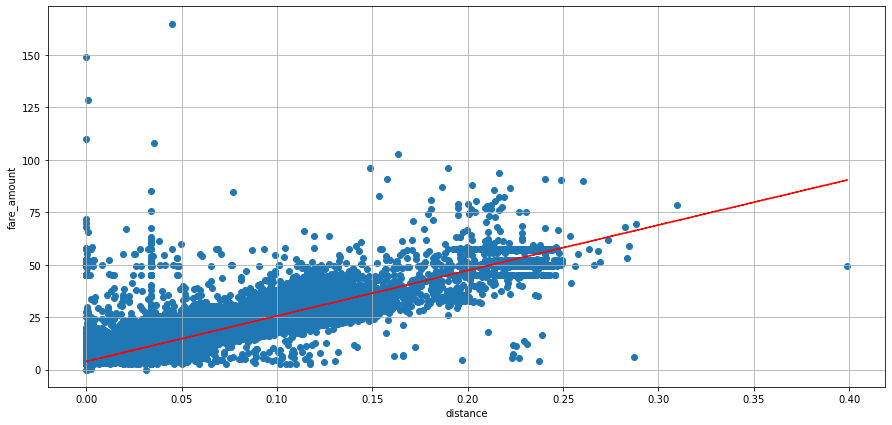

In [164]:
plt.figure(figsize=(15, 7))
plt.scatter(ny_df['distance'], ny_df['fare_amount'])
plt.plot(ny_df['distance'], ny_df['distance']*model.coef_ + model.intercept_,
        color='red', linestyle='--')
plt.xlabel('distance')
plt.ylabel('fare_amount')
plt.grid(True)
plt.show()

In [154]:
# 학습에 사용되는 형태로 데이터 변환
df = ny_df[['distance', 'fare_amount']]
print('shape :', df.shape)

shape : (48869, 2)


In [155]:
arrX = np.array(df.distance)
arrY = np.array(df.fare_amount)

print('arrx : ', arrX.shape, 'arry : ', arrY.shape)

arrx :  (48869,) arry :  (48869,)


In [156]:
# 1차원 -> 2차원
arrX = arrX.reshape(-1, 1)
print('arrX : ', arrX.shape, arrX.ndim, 'arry : ', arrY.shape, arrY.ndim)

arrX :  (48869, 1) 2 arry :  (48869,) 1


### [3] 학습 방법 선택 및 모델 생성
---
- 시간에 따른 점수 예측
- 데이터 + 라벨 => 지도학습
- 선형 데이터 분포 => 선형 모델 적용

In [157]:
# 모델 객체 생성
model = LinearRegression()

In [158]:
# 학습 => 트레이닝 데이터 사용
# fit()메서드 => 2차원 형태 데이터
model.fit(arrX, arrY)

LinearRegression()

In [159]:
# 모델 파라미터 => w 가중치, b 절편
print('w : ', model.coef_, 'b : ', model.intercept_)

w :  [216.93193602] b :  3.8506372299980667


### [4] 모델 평가
---
- 테스트(검증) 데이터로 평가
- score()
    * 분류 : 정답 --- 예측답 => 맞춘 정도
        - 정확도(accuracy)
    * 회귀 : 정답 --- 예측답 => 차이 오차(Error)
        - 손실함수(Loss/Cost Function) : MSE, MAE, RMSE 0 ~ 1 낮을수록 좋음
        - R2 계수 : 0 ~ 1 높을수록 좋음

In [160]:
# 회귀 => 결정계수 R^2 반환
model.score(arrX, arrY)

0.7729989259864704

In [161]:
# 오차 확인
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 예측값 추출
preY = model.predict(arrX)

mae = mean_absolute_error(arrY, preY)
mse = mean_squared_error(arrY, preY)

print(mae, mse)

2.3224492046153307 19.970699132493195
